In [1]:
from pathgen.utils.seeds import set_seed

global_seed = 7583927
set_seed(global_seed)

In [2]:
from pathgen.utils.paths import project_root

experiment_name = "new"
experiment_root = project_root() / "experiments" / experiment_name

## 2. Sampling at a slide level
We want the samples in the different sets (train, validate, and test) to come from seperate slides. Test is it's own dataset, but validate has to be broken off from train on a per-slide basis. We want the split to take into account the number of patches in each set (because it is the patches that we are interested in). Let's base the split so that the validate set has about 30% of the tumor patches in it. Baseing it on the tumor patches makes sense because they are the class with the smallest number of samples.

Our algorithm for splitting will work like so:
1. Work out the total number of tumor patches in the whole dataset.
2. Work out what 30% (or whatever the amount is) of the total patches is.
3. Start counting with 0 patches and 0 slides in the validation set.
4. Randomly select a slide in training and move it to validation.
5. Add the number of patches in that slide to the total.
6. Repeat from 4 until the total number of patches is greater than 30% of the total.

In [3]:
from pathgen.preprocess.patching import SlidesIndex

train_index = SlidesIndex.load(experiment_root / 'train_index')
test_index = SlidesIndex.load(experiment_root / 'test_index')
len(train_index), len(test_index)

(270, 129)

In [4]:
import random
from typing import Tuple

def split_on_slide(index: SlidesIndex, label: str, fraction: float) -> Tuple[SlidesIndex, SlidesIndex]:
    # compute the number of patches in each fraction
    summary = index.summary()
    total = summary[label].sum()
    split_count = int(total * fraction)
    
    # perform the split on the indices
    remaining_indices = list(range(len(summary)))
    random.shuffle(remaining_indices)
    split_indices = []
    total_split_patches = 0
    while total_split_patches < split_count:
        slide_idx = remaining_indices[0]  # front
        label_count = summary.iloc[slide_idx][label]
        total_split_patches += label_count
        remaining_indices.pop(0)
        split_indices.append(slide_idx)

    # create the indexes
    return index.select(remaining_indices), index.select(split_indices)

training_index, validation_index = split_on_slide(train_index, 'tumor', 0.3)
print(len(training_index))
print(len(validation_index))
training_index.summary()['tumor'].sum(), validation_index.summary()['tumor'].sum()

202
68


(214807, 92787)

Now that we have the two sets, we can sample the patches from them.

## 3. Sampling patches from across all the slides

In [5]:
# from pathgen.preprocess.patching import combine

from typing import List

import pandas as pd
import numpy as np

from pathgen.preprocess.patching import PatchSet

def combine(patchsets: List[PatchSet]) -> PatchSet:
    def to_frame(ps: PatchSet) -> pd.DataFrame:
        frame = ps.df.copy(deep=True)
        for attr in ["patch_size", "level", "slide_index", "dataset_name"]:
            value = getattr(ps, f"_{attr}", None)
            if attr not in frame.columns:
                frame[attr] = value
        return frame

    # create one big data frame with all the patch data in it
    frames = [to_frame(ps) for ps in patchsets]
    combined_df = pd.concat(frames, ignore_index=True)
    
    # optimise
    def is_unique(s):
        a = s.to_numpy()
        return (a[0] == a).all()

    cols = ["patch_size", "level", "slide_index", "dataset_name"]
    args = {}
    for col in cols:
        if is_unique(combined_df[col]):
            series = combined_df[col]
            args[col] = series[0]
            combined_df.pop(col)
    args["df"] = combined_df

    return PatchSet(**args)

training_patchset = combine(training_index.patches)
training_patchset.summary()

label,background,normal,tumor
0,0,5827865,214807


In [6]:
validation_patchset = combine(validation_index.patches)
validation_patchset.summary()

label,background,normal,tumor
0,0,1610737,92787


In [7]:
testing_patchset = combine(test_index.patches)
testing_patchset.summary()

label,background,normal,tumor
0,0,3410036,244550


In [8]:
from pathgen.preprocess.sampling import sample

training_samples = sample(training_patchset, 35000)  # 70,000 total
training_samples.summary()

label,background,normal,tumor
0,0,35000,35000


In [9]:
validation_samples = sample(validation_patchset, 15000)  # 30,000 total
validation_samples.summary()

label,background,normal,tumor
0,0,15000,15000


In [10]:
testing_samples = sample(testing_patchset, 15000)  # 30,000 total
testing_samples.summary()

label,background,normal,tumor
0,0,15000,15000


## 4. Export the patches to disk

In [11]:
training_samples.export(experiment_root / 'train_patches')

Exporting patches for: 1, 2, 3, 4, 6, 7, 8, 9, 11, 13, 14, 15, 16, 19, 20, 21, 23, 25, 26, 27, 29, 30, 31, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 73, 75, 76, 78, 80, 81, 82, 85, 86, 87, 88, 89, 91, 92, 93, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 108, 110, 112, 113, 117, 118, 119, 121, 122, 123, 124, 125, 127, 128, 131, 132, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 171, 172, 173, 174, 175, 176, 177, 180, 181, 182, 183, 185, 186, 187, 188, 190, 191, 193, 194, 196, 198, 199, 200, 201, 202, 203, 206, 207, 208, 209, 210, 211, 212, 214, 215, 216, 217, 219, 220, 222, 223, 224, 227, 229, 230, 231, 234, 235, 236, 237, 238, 240, 241, 242, 243, 244, 245, 247, 249, 250, 251, 252, 253, 254, 255, 257, 259, 260, 261, 262, 263, 264, 266, 267, 268, 269, Complete.


In [12]:
print('validation')
validation_samples.export(experiment_root / 'valid_patches')
print('testing')
testing_samples.export(experiment_root / 'test_patches')

validation
Exporting patches for: 0, 5, 10, 12, 17, 18, 22, 24, 28, 32, 33, 37, 45, 48, 49, 52, 59, 65, 68, 74, 77, 79, 83, 84, 90, 94, 95, 101, 106, 109, 111, 114, 115, 116, 120, 126, 129, 130, 133, 140, 147, 153, 159, 169, 170, 178, 179, 184, 189, 192, 195, 197, 204, 205, 213, 218, 221, 225, 226, 228, 232, 233, 239, 246, 248, 256, 258, 265, Complete.
testing
Exporting patches for: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, Complete.


Let's display some of the patches to check they are ok

In [13]:
import random
from PIL import Image

from IPython.display import Image
import pathlib

from pathlib import Path 
import matplotlib.pyplot as plt

def get_random_images(source_dir: Path, num_images: int) -> [Image]:
    image_paths = list(source_dir.glob('*.png'))
    print(source_dir)
    print(len(image_paths))
    return random.sample(image_paths, num_images)

def show_random_patches(source_dir: Path) -> None:
    images = get_random_images(source_dir, 9)
    
    plt.figure(figsize=(10,10))

    for i, img_path in enumerate(images):
      img_path = str(img_path)
    
      # the number of images in the grid is 3*3 (9)
      plt.subplot(3,3,i+1)
    
      img = plt.imread(img_path)
      plt.imshow(img)
      plt.title(Path(img_path).name)
      plt.axis("off")

    plt.show()
    plt.close()

/home/ubuntu/pathgen/experiments/new/train_patches/normal
35000


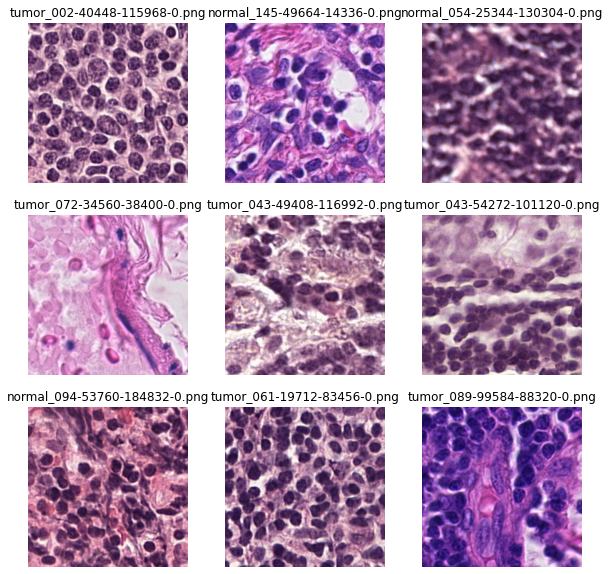

In [14]:
normal_train_patches_dir = experiment_root / 'train_patches' / 'normal'
show_random_patches(normal_train_patches_dir)

/home/ubuntu/pathgen/experiments/new/train_patches/tumor
35000


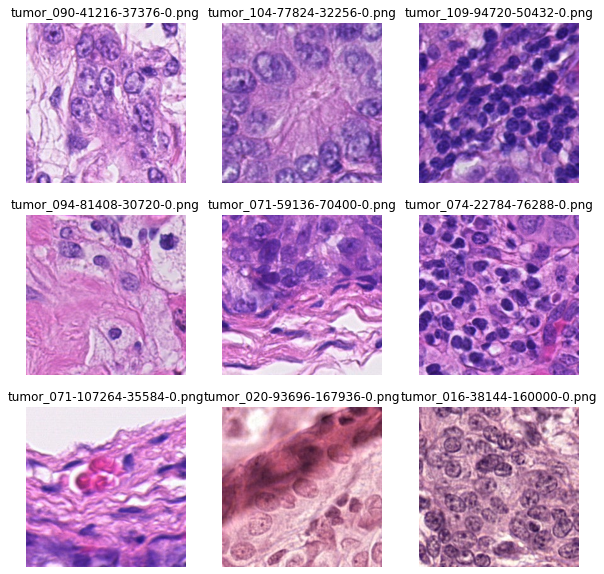

In [15]:
tumor_train_patches_dir = experiment_root / 'train_patches' / 'tumor'
show_random_patches(tumor_train_patches_dir)